# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
from functools import reduce
import glob

import tqdm as tqdm
from tqdm.autonotebook import tqdm
tqdm.pandas()

import sys
sys.path.append('iads/')

from utils import *

# Importation de la librairie iads
import iads as iads
# importation de LabeledSet
from iads import LabeledSet as ls
# importation de Classifiers
from iads import Classifiers as cl
# importation de utils
from iads import utils as ut

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/users/Etu4/3502264/.local/lib/python3.5/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Chargement des données (base MovieLens + enrichissements)

In [2]:
# Chargement des données MovieLens

print("Chargement des données MoviesLens")
for fname in glob.glob("ml-20m/*.csv"):
    print("\t {}...".format(fname))
    name = fname.split('/')[1].split('.')[0].replace('-', '_')
    vars()[name] = pd.read_csv(fname, encoding='utf8')
print("Done")

movies.head()
genome_scores.head()
genome_tags.head()
links.head()
ratings.head()
tags.head()

Chargement des données MoviesLens
	 ml-20m/movies.csv...
	 ml-20m/genome-scores.csv...
	 ml-20m/genome-tags.csv...
	 ml-20m/links.csv...
	 ml-20m/ratings.csv...
	 ml-20m/tags.csv...
Done


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [3]:
# Chargement des données complémentaires

print("Chargement des données complémentaires")
for fname in glob.glob("ml-20m/*.pkl"):
    print("\t {}".format(fname))
    name = fname.split('/')[1].split('_')[0]
    vars()[name] = pkl.load(open(fname, "rb"))
print("Done")



Chargement des données complémentaires
	 ml-20m/act_v2.pkl
	 ml-20m/film_v2.pkl
	 ml-20m/crew_v2.pkl
Done


In [4]:
len(tags.tag.unique())
genome_tags.shape

38644

(1128, 2)

In [5]:
act[0][0]

{'cast_id': 14,
 'character': 'Woody (voice)',
 'credit_id': '52fe4284c3a36847f8024f95',
 'gender': 2,
 'id': 31,
 'name': 'Tom Hanks',
 'order': 0,
 'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'}

In [6]:
crew[0][0]

{'credit_id': '52fe4284c3a36847f8024f49',
 'department': 'Directing',
 'gender': 2,
 'id': 7879,
 'job': 'Director',
 'name': 'John Lasseter',
 'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'}

In [7]:
film[:1]

[{'adult': False,
  'backdrop_path': '/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg',
  'genre_ids': [16, 35, 10751],
  'id': 862,
  'original_language': 'en',
  'original_title': 'Toy Story',
  'overview': "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",
  'popularity': 22.773,
  'poster_path': '/rhIRbceoE9lR4veEXuwCC2wARtG.jpg',
  'release_date': '1995-10-30',
  'title': 'Toy Story',
  'video': False,
  'vote_average': 7.9,
  'vote_count': 9550}]

## Mise en forme des données

In [8]:
unique_cat = set(reduce(lambda a, b: a + b, movies.apply(
    lambda x: x.genres.split('|'), axis=1)))

In [9]:
movies[list(unique_cat)] = pd.DataFrame(np.zeros((movies.shape[0], 
                                                  len(unique_cat))))
for i, row in movies.iterrows():
    movies.loc[i, row['genres'].split('|')] = 1

In [10]:
# %load preprocessing.py
#!/usr/bin/env python3

"""

"""

def process_ratings(ratings, fname_to_create):
    """FIXME! briefly describe function

    :param ratings:
    :param fname_to_create:
    :returns:
    :rtype:

    """

    # Calculate ratings mean of users
    df_ratings = ratings[['movieId', 'rating']].groupby(
        ['movieId'], as_index=False).mean()

    # Count number of ratings by movie
    df_ratings['nb_ratings'] = ratings.groupby(
        ['movieId'], as_index=False).count().loc[:, 'rating']

    df_ratings.to_csv(fname_to_create, index=False)


def process_tags(tags, fname_to_create):
    """FIXME! briefly describe function

    :param tags:
    :param fname_to_create:
    :returns:
    :rtype:

    """

    df_tags = tags[['movieId', 'userId']].groupby(
        ['movieId'], as_index=False).count().rename(
        columns={'userId': 'nb_tags'})

    df_tags['all_tags'] = tags.groupby(['movieId'], as_index=False)[
        'tag'].progress_apply(list)

    df_tags['existing_tags'] = df_tags[['all_tags']].progress_apply(
        lambda line: list(filter(
            lambda tag: not genome_tags[genome_tags['tag'] == tag].empty,
            line['all_tags'])), axis=1)

    df_tags['existing_tagsId'] = df_tags[['existing_tags']].progress_apply(
        lambda line: list(map(
            lambda tag: genome_tags[genome_tags['tag']
                                    == tag]['tagId'].iloc[0],
            line['existing_tags'])), axis=1)

    df_tags['existing_tagsRelevance'] = df_tags[['movieId', 'existing_tagsId']].progress_apply(
        lambda line: np.array(
            [*map(lambda tagId:
                  genome_scores[(genome_scores['movieId'] == line.movieId) &
                                (genome_scores['tagId'] == tagId)]['relevance'].values,
                  line['existing_tagsId'])]).ravel(), axis=1)

    df_tags['mean_relevance'] = df_tags[['existing_tagsRelevance']].progress_apply(
        lambda line: line['existing_tagsRelevance'].mean(), axis=1).fillna(0)

    df_tags.to_csv(fname_to_create, index=False)


def main():

    process_ratings(ratings, "datasets/ratings.csv")
    process_tags(tags, "datasets/tags.csv")


if __name__ == "__main__":
    process_ratings(ratings, "datasets/ratings.csv")


'\n\n'

In [11]:
df_ratings = pd.read_csv("datasets/ratings.csv")
df_tags = pd.read_csv('datasets/tags.csv')

In [12]:
try:
    df_movies = reduce(lambda df1, df2: pd.merge(df1, df2), 
                       [movies.drop(columns='title', inplace=True), 
                        links,
                        pd.DataFrame(film).rename(columns={'id':'tmdbId'})])
except:
    df_movies = reduce(lambda df1, df2: pd.merge(df1, df2), 
                       [movies, 
                        links,
                        pd.DataFrame(film).rename(columns={'id':'tmdbId'})])


In [13]:
# %load utils.py
#!/usr/bin/env python3

from datetime import datetime

import iads as iads
from iads import LabeledSet as ls


def delete_columns(data, columns_to_drop):
    """ Delete specified columns in columns_to_drop from the dataframe
    :param data: dataframe from which to delete columns
    :param columns_to_drop: list of columns to delete
    :returns: a dataframe
    :rtype: pandas.DataFrame
    """

    for column in columns_to_drop:
        if column in data.columns:
            data.drop(column, axis=1, inplace=True)

    return data


def transform_date(x):
    """FIXME! briefly describe function

    :param x:
    :returns:
    :rtype:

    """

    try:
        return datetime.strptime(x, '%Y-%m-%d').year
    except BaseException:
        try:
            return int(x)
        except BaseException:
            return 0


def createLabeledSet(X, y):
    """FIXME! briefly describe function

    :param X:
    :param y:
    :returns:
    :rtype:

    """

    l = ls.LabeledSet(X.shape[0])
    for i, j in zip(X, y):
        l.addExample(i, j)

    return l

def normalize(X):
    """ Returns a normalized (between 0 and 1) array of X. Normalizes each
    column separatly.
    :param X: independent variables, features.
    :returns: a normalized X
    :rtype: np.array
    """

    norm_X = np.zeros_like(X)
    for i in range(X.shape[1]):
        tmp = X[:, i].copy()
        maxi, mini = np.nanmax(tmp), np.nanmin(tmp)
        norm_X[:, i] = (tmp - mini) / (maxi - mini)

    return norm_X

def split(labeledSet, test_size):
    """
    """
    
    indexes = np.arange(labeledSet.size())
    np.random.shuffle(indexes)
    
    shuffeledSet = ls.LabeledSet(2)
    for i in indexes:
        shuffeledSet.addExample(labeledSet.getX(i), labeledSet.getY(i))
    
    trainSet, testSet = ls.LabeledSet(2), ls.LabeledSet(2)
    test_range = int(labeledSet.size() * test_size)
    
    for i in range(labeledSet.size() - test_range):
        trainSet.addExample(shuffeledSet.getX(i), shuffeledSet.getY(i))
    
    for i in range(labeledSet.size() - test_range, labeledSet.size()):
        testSet.addExample(shuffeledSet.getX(i), shuffeledSet.getY(i))
    
    return trainSet, testSet

In [14]:
# Defining the target variable and the independant variables
df_y = df_movies['vote_average']
df_X = df_movies.copy()

# Deleting useless columns
cols_to_drop = ['movieId', 'genres', 'imdbId', 'tmdbId', 'backdrop_path', 'genre_ids', 
                'original_title', 'overview', 'poster_path', 'vote_average', 
                'vote_count', 'video', 'title']

df_X = delete_columns(df_X, cols_to_drop)

# Label encoding 
df_X['adult'] = df_X['adult'].apply(int)
df_X['original_language'] = df_X['original_language'].astype('category').cat.codes
df_X['release_date'] = df_X['release_date'].apply(lambda x: transform_date(x))
df_X.release_date[df_X.release_date == 0] = df_X.release_date.median()

# Drop NaN values
df_X = df_X.dropna()
# Transform to numpy arrays
X, y = df_X.values, df_y.values
# Normalize data
X = normalize(X)
# Create LabeledSet
regressor_set = createLabeledSet(X, y)

/users/Etu4/3502264/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [49]:
df_X.head()

,Animation,War,Western,Children,Documentary,Romance,Film-Noir,Comedy,Action,Sci-Fi,...,Horror,(no genres listed),Fantasy,Thriller,Drama,IMAX,adult,original_language,popularity,release_date
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,19,22.773,1995
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,19,2.947,1995
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,19,6.076,1995
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,19,2.917,1995
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,19,6.817,1995


## Regression Model

In [37]:
class Regressor(cl.Classifier):
    """ Classe réprésentant une régression.
    """

    def __init__(self, dimension_kernel, learning_rate, kernel, max_iter=10):
        """
        """

        self.dimension_kernel = dimension_kernel
        self.learning_rate = learning_rate
        self.kernel = kernel
        self.max_iter = max_iter
        self.w = np.zeros(self.dimension_kernel)
        
    def predict(self, x):
        """ 
        """
        
        return self.kernel.transform(x).dot(self.w.T)
    

    def train(self, labeledSet):
        """ 
        """
        for _ in range(self.max_iter):
            f = self.kernel.transform(labeledSet.x).dot(self.w.T).reshape(-1, 1)
            mse_g = -2 * (self.kernel.transform(labeledSet.x) * 
                          (labeledSet.y - f)).mean(axis=0)
            self.w -= self.learning_rate * mse_g
            
    def accuracy(self, labeledSet):
        """
        """
        mse = np.mean((self.predict(labeledSet.x)[:, np.newaxis] - labeledSet.y)**2)
        print("MSE : {}".format(mse), "\n===")
        print("RMSE: {}".format(np.sqrt(mse)), "\n====")
        
    def plot_results(self, y, y_pred, title, cmap='viridis'):
        """
        """
        fig, ax = plt.subplots(1, figsize=(16, 6))
        results = pd.DataFrame(np.hstack((y, y_pred[:, np.newaxis])), 
                               columns=['y', 'y_pred'], 
                               index=range(len(y_pred)))
        results.plot(ax=ax, cmap=cmap)
        plt.title(title, fontsize=16)

In [16]:
# Splitting data
train_set, test_set = split(regressor_set, 0.2)

In [27]:
# Declaring kernels
nokernel = cl.NoKernel()
kernel_bias = cl.KernelBias()
kernel_poly = cl.KernelPolytwo()

### Regression sans Kernel

MSE : 3.450993779440629 
===
RMSE: 1.8576850592715195 
====


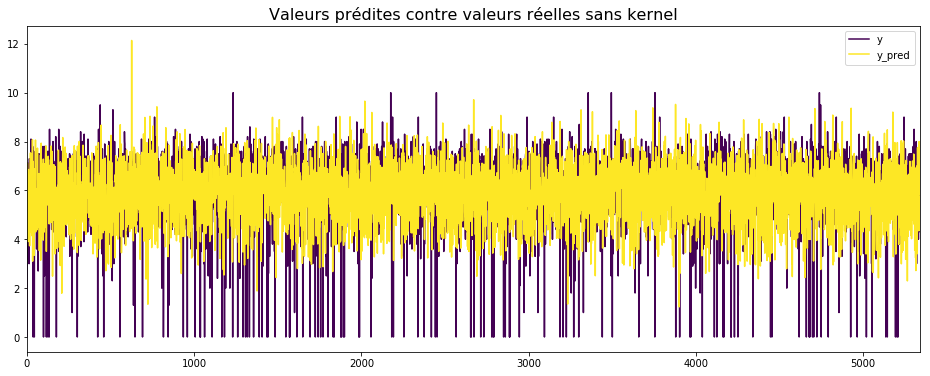

In [38]:
# Declaring Regressor
regressor = Regressor(regressor_set.x.shape[1], 0.1, nokernel, 200)
# Training Regressor
regressor.train(train_set)
# Testing Regressor
y_pred = regressor.predict(test_set.x)
# Scoring
regressor.accuracy(test_set)
# Plotting Results
regressor.plot_results(test_set.y, y_pred, 
                       'Valeurs prédites contre valeurs réelles sans kernel')

### Regression avec Kernel bias

MSE : 2.1100275917385716 
===
RMSE: 1.4525934020704387 
====


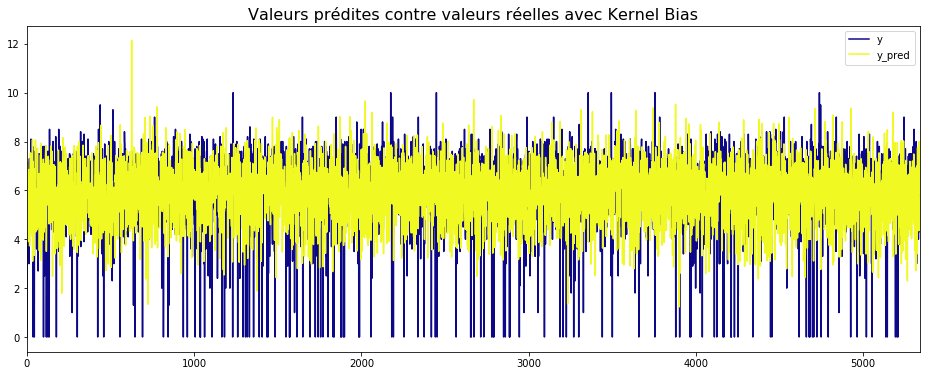

In [42]:
# Declaring Regressor
regressor_bias = Regressor(regressor_set.x.shape[1]+1, 0.1, kernel_bias, 200)
# Training Regressor
regressor_bias.train(train_set)
# Testing Regressor
ypred_bias = regressor_poly.predict(test_set.x)
# Scoring
regressor_bias.accuracy(test_set)
# Plotting Results
regressor_bias.plot_results(test_set.y, y_pred,
                           'Valeurs prédites contre valeurs réelles avec Kernel Bias',
                           cmap='plasma')

### Regression avec Kernel poly

MSE : 2.0683085288924663 
===
RMSE: 1.4381615100163354 
====


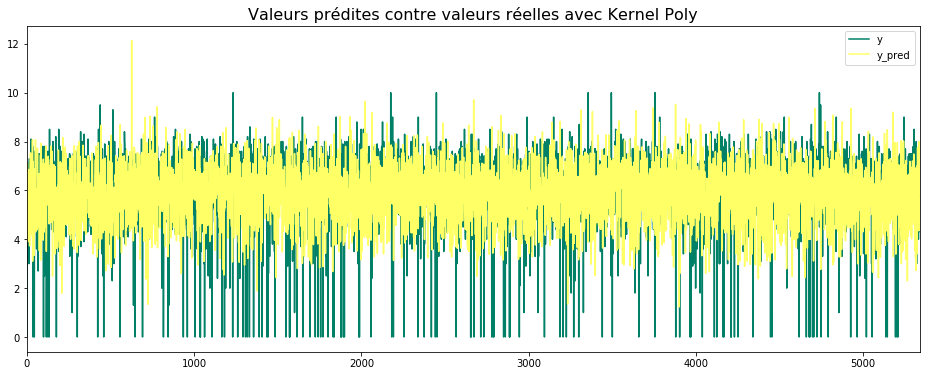

In [47]:
# Declaring Regressor
regressor_poly = Regressor((regressor_set.x.shape[1]*2)+1, 0.1, kernel_poly, 200)
# Training Regressor
regressor_poly.train(train_set)
# Testing Regressor
ypred_poly = regressor_poly.predict(test_set.x)
# Scoring
regressor_poly.accuracy(test_set)
# Plotting Results
regressor_poly.plot_results(test_set.y, y_pred,
                            title='Valeurs prédites contre valeurs réelles avec Kernel Poly',
                            cmap='summer')

## Classification 

## Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [ ]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
actors = dict()
actors_inv = dict()
for lista in act:
    for a in lista:
        # affecte une valeur à une clé si la clé n'est pas utilisée
        res = actors.setdefault(a['name'], len(actors))
        if res == len(actors)-1:
            actors_inv[len(actors)-1] = a['name']

# Exemple de transformation supplémentaire
# Dans combien de films de base joue Tom Hanks? (Réponse 57)
# Dans combien de comédies...

# => On voit qu'il est possible de créer facilement des nouvelles caractéristiques qui
# apporteront des informations utiles pour certaines tâches
